## Моделирование молекулярной динамики

   - Система: ГЦК решётка $7\times7\times7$ частиц;
   - Постоянная решётки: $a = 1.75~\sigma $;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Начальная температура: $T_i = 0.3~\varepsilon / k_B$;
   - Конечная температура: $T_f = 10^{-5}~\varepsilon / k_B$;
   - Скорости охлаждения: $v_1 = 0.02~\varepsilon / k_B\tau; v_2 = 0.001~\varepsilon / k_B\tau$;
   - Термостат: масштабирование скоростей;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma $;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число "неравновесных" итераций: $40000$;
   - Равновесные характеристики системы рассчитывалась через каждые $2500$ шагов;
   - Число ансамблей $N=1000$;
   - Подсчёт состоял из $2N+499$ шагов: $500$ на уравновешивание системы при фиксированной температуре и $2N-1$ на усреднение по ансамблям (к первому ансамблю относятся шаги с $1$ по $N$ шаг, ко второму - с $2$ по $N+1$ и т. д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые $N$ шагов;

#### Импорт необходимых библиотек

In [1]:
from copy import deepcopy
from datetime import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.dirname(sys.path[0]))

import scripts.constants as con
from scripts.postprocessing import PostProcessor, RegressionRDF

#### Настройки рисунков

In [2]:
FIGSIZE = (7, 7)
FONTSIZE = 14

plt.style.use('seaborn')
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE
plt.rcParams['legend.fontsize'] = FONTSIZE
plt.rcParams['axes.titlesize'] = FONTSIZE
plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['font.size'] = FONTSIZE

COLORS = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'purple',
    'orange',
    'olive',
    'yellow',
    'brown',
    'pink',
    'gray',
    'lime',
    'slateblue',
    'crimson',
    'darkviolet',
    'sienna',
    'coral',
)


#### Путь к файлам с данными

In [3]:
CURRENT_DATA_NORMAL = '2021-05-19_cooling_normal_0.3'
CURRENT_DATA_SLOW = '2021-05-19_cooling_slow_0.3'
PLOT_FILENAME_POSTFIX = 'slow_cooling'

In [4]:
PATH_TO_CURRENT_DATA_NORMAL = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_NORMAL)
PATH_TO_CURRENT_DATA_SLOW = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_DATA_SLOW

'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-05-19_cooling_slow_0.3'

In [5]:
PATH_TO_CURRENT_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_PLOTS

'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\plots\\2021-05-19_cooling_slow_0.3'

#### Пользовательские функции

In [6]:
def get_merged_data(
    old_data : pd.DataFrame, 
    data_filename_prefix : str, 
    merge_column_name : str, 
    old_column_name : str, 
    temperature : float, 
    columns : list = None,
):
    df = pd.read_csv(
        f'{data_filename_prefix}{temperature:.5f}.csv',
        sep=';',
    )
    if columns is not None:
        df = df[columns]
    merged_data = old_data.merge(
        right=df,
        how='outer',
        on=merge_column_name,
    )
    merged_data = merged_data.rename(columns={old_column_name: f'{temperature:.5f}'})
    return merged_data

In [7]:
def save_plot(filename):
    plt.savefig(
        os.path.join(PATH_TO_CURRENT_PLOTS, filename)
    )

#### Параметры системы, при которых были подчитаны функции радиального распределения, среднеквадратичные смещения и т.д.

In [8]:
setups_normal, setups_slow = [], []
for filename in os.listdir(PATH_TO_CURRENT_DATA_NORMAL)[::-1]:
    if filename.startswith('rdf'):
        parts = filename[:-4].split('_')
        setup = {
            'temperature': float(parts[2]), 
            'pressure': float(parts[4]) if 'P' in parts else None,
            'heating_velocity': float(parts[6]) if 'HV' in parts else None,
            
        }
        if len(setups_normal) < 2:
            setups_normal.append(setup)
        
for filename in os.listdir(PATH_TO_CURRENT_DATA_SLOW)[::-1]:
    if filename.startswith('rdf'):
        parts = filename[:-4].split('_')
        setup = {
            'temperature': float(parts[2]), 
            'pressure': float(parts[4]) if 'P' in parts else None,
            'heating_velocity': float(parts[6]) if 'HV' in parts else None,
            
        }
        setups_slow.append(setup)
        
setups_normal

[{'temperature': 0.29979, 'pressure': -2.71447, 'heating_velocity': 0.02},
 {'temperature': 0.05036, 'pressure': -0.48803, 'heating_velocity': 0.02}]

#### Температуры, для которых функция радиального распределения предсказывается

In [9]:
test_temperatures = [setup['temperature'] for setup in setups_normal]

#### Инициализация объекта для обработки данных и вывод таблицы значений функции радиального распределения

In [10]:
pp_normal = PostProcessor(
    path_to_data=PATH_TO_CURRENT_DATA_NORMAL, 
    path_to_plots=PATH_TO_CURRENT_PLOTS, 
    plot_filename_postfix=PLOT_FILENAME_POSTFIX, 
    setups=setups_normal,
)
pp_slow = PostProcessor(
    path_to_data=PATH_TO_CURRENT_DATA_SLOW, 
    path_to_plots=PATH_TO_CURRENT_PLOTS, 
    plot_filename_postfix=PLOT_FILENAME_POSTFIX, 
    setups=setups_slow,
)
pp_slow.rdf.data

,radius,setup_0,setup_1,setup_2,setup_3,setup_4,setup_5,setup_6,setup_7,setup_8,setup_9,setup_10,setup_11,setup_12,setup_13,setup_14,setup_15,setup_16
0,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,6.08,0.984181,0.957964,0.876962,0.836915,0.830279,0.822058,0.831073,0.828493,0.830347,0.826443,0.823897,0.823434,0.818909,0.822503,0.823997,0.823697,0.823168
608,6.09,0.984333,0.957233,0.873615,0.830924,0.823593,0.816432,0.828778,0.828540,0.829097,0.831643,0.827192,0.828280,0.826093,0.833551,0.832976,0.830777,0.834216
609,6.10,0.984272,0.959026,0.876363,0.823148,0.823287,0.813517,0.831786,0.829448,0.836369,0.836319,0.833523,0.836753,0.835357,0.843953,0.845252,0.842498,0.851033
610,6.11,0.983301,0.961080,0.877985,0.817742,0.821531,0.815389,0.838561,0.840600,0.844413,0.848139,0.844066,0.850119,0.847277,0.858183,0.860390,0.862558,0.869601


#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

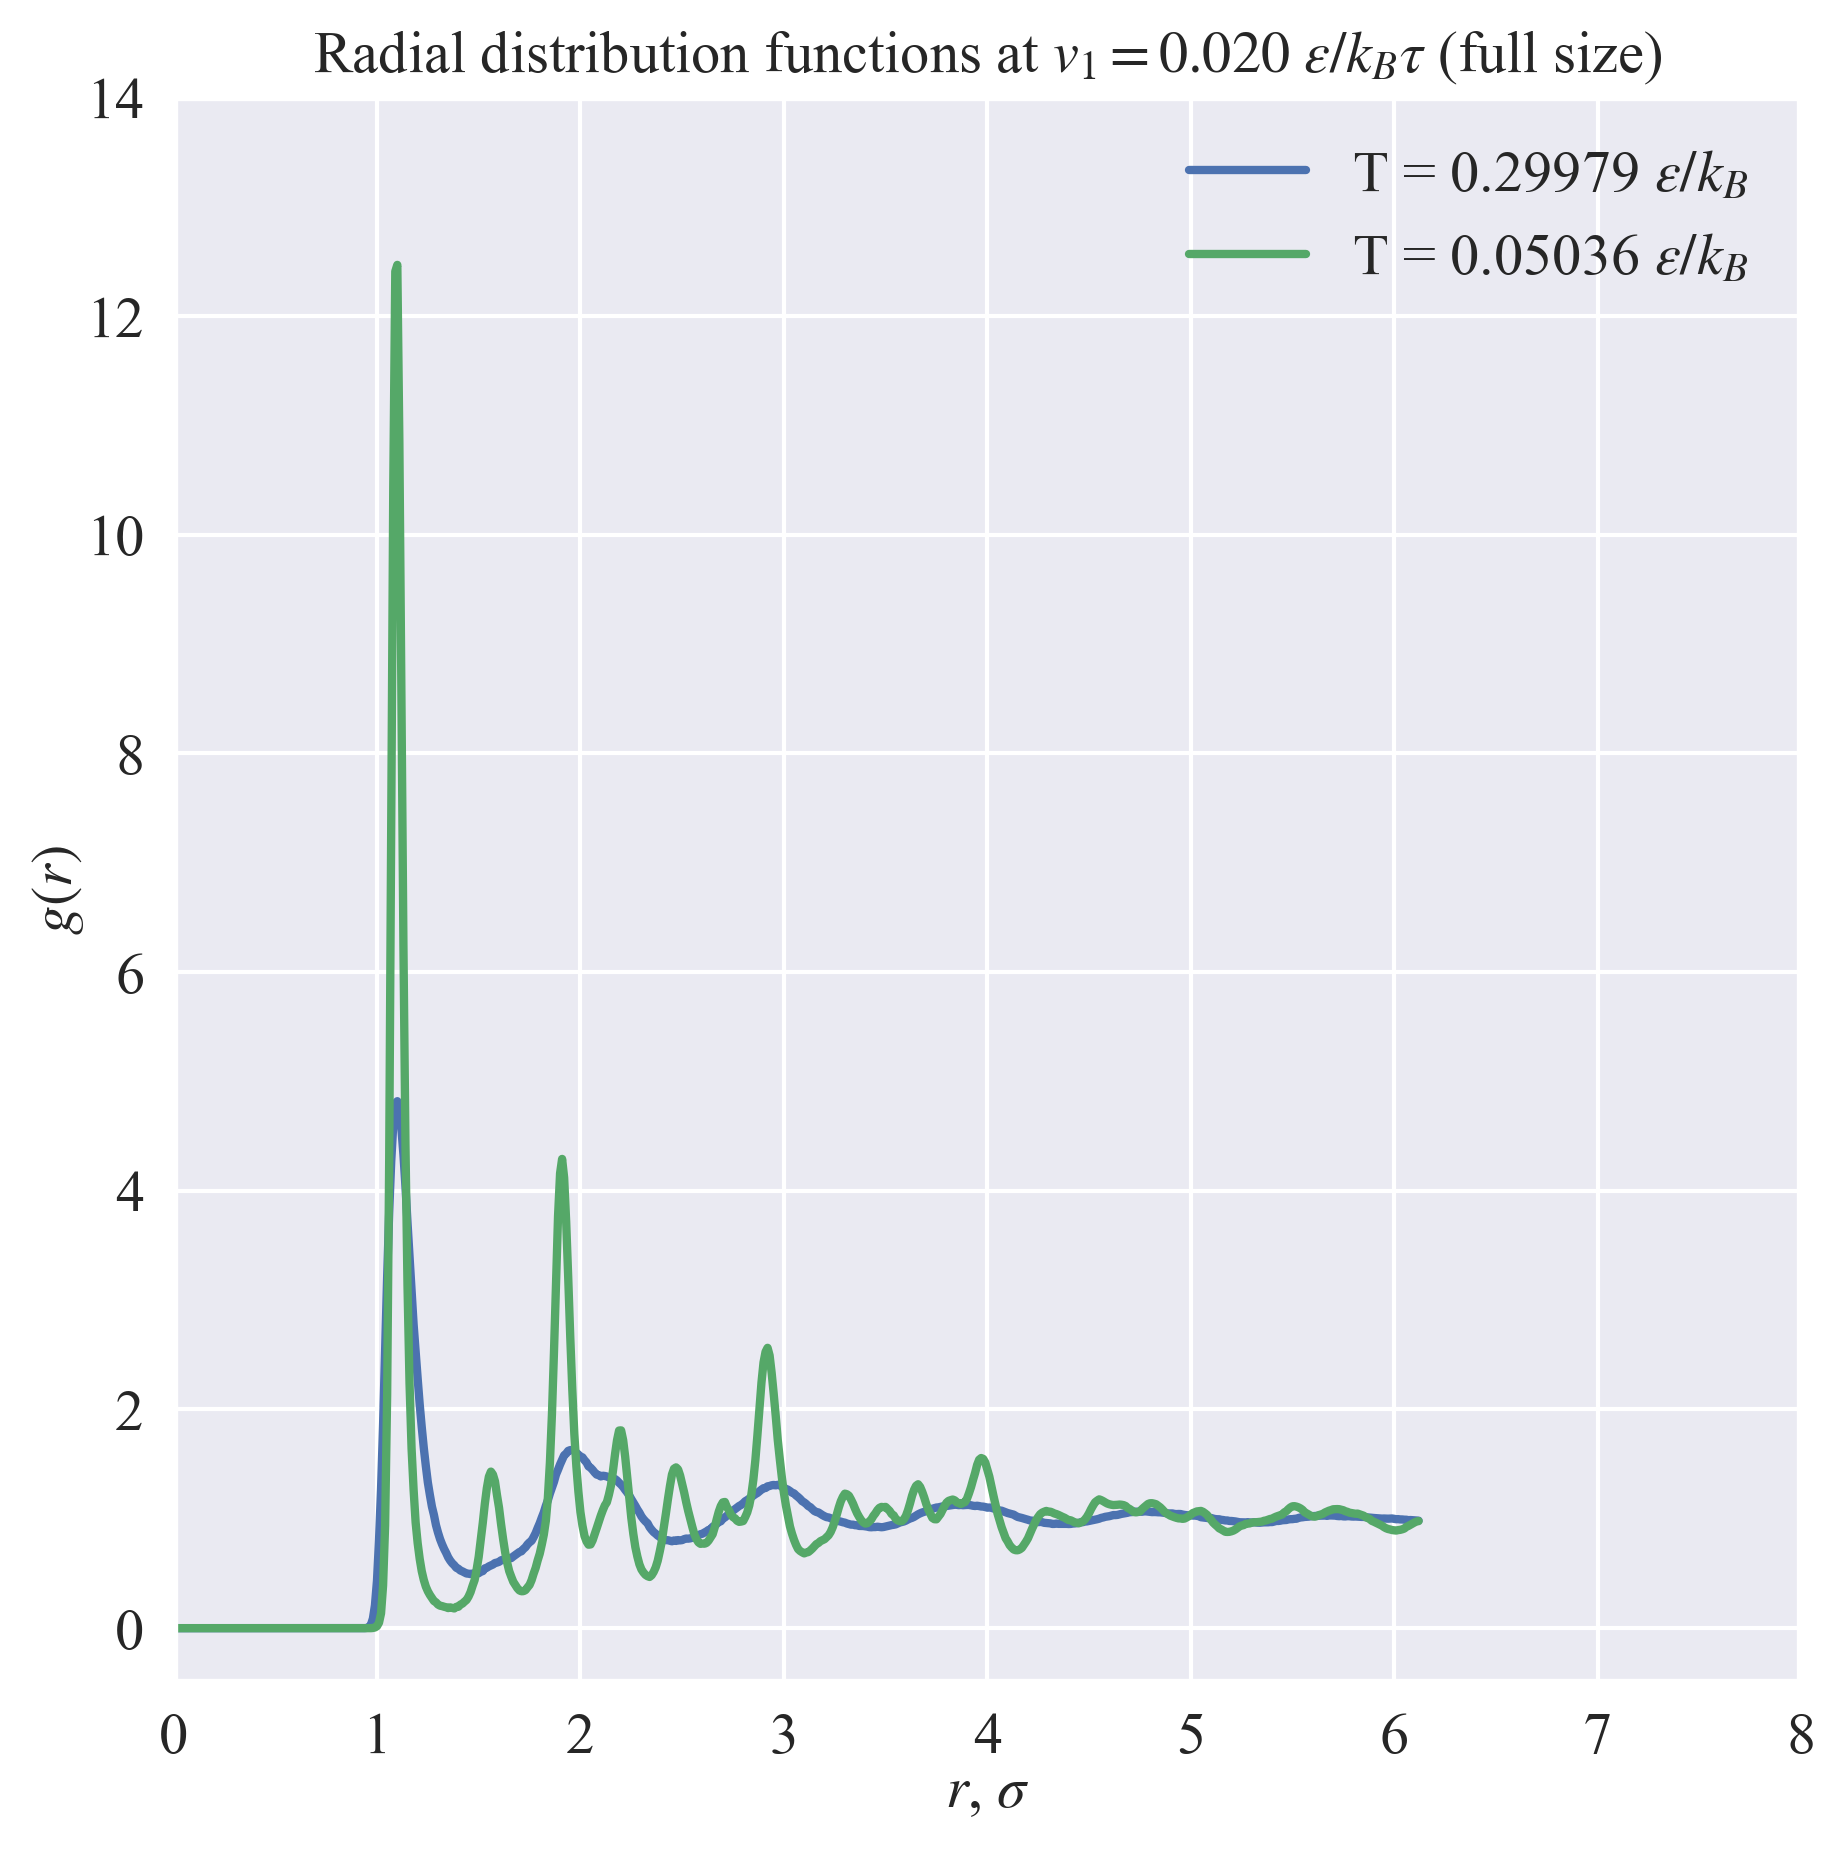

In [11]:
pp_normal.plot_rdf(
    shift=0.0,
    left=0,
    right=8,
    bottom=-0.5, 
    top=14,
    figsize=FIGSIZE,
    title=r'Radial distribution functions at $v_1 = 0.020~\varepsilon / k_B\tau$ (full size)',
    filename_postfix='full_size',
)

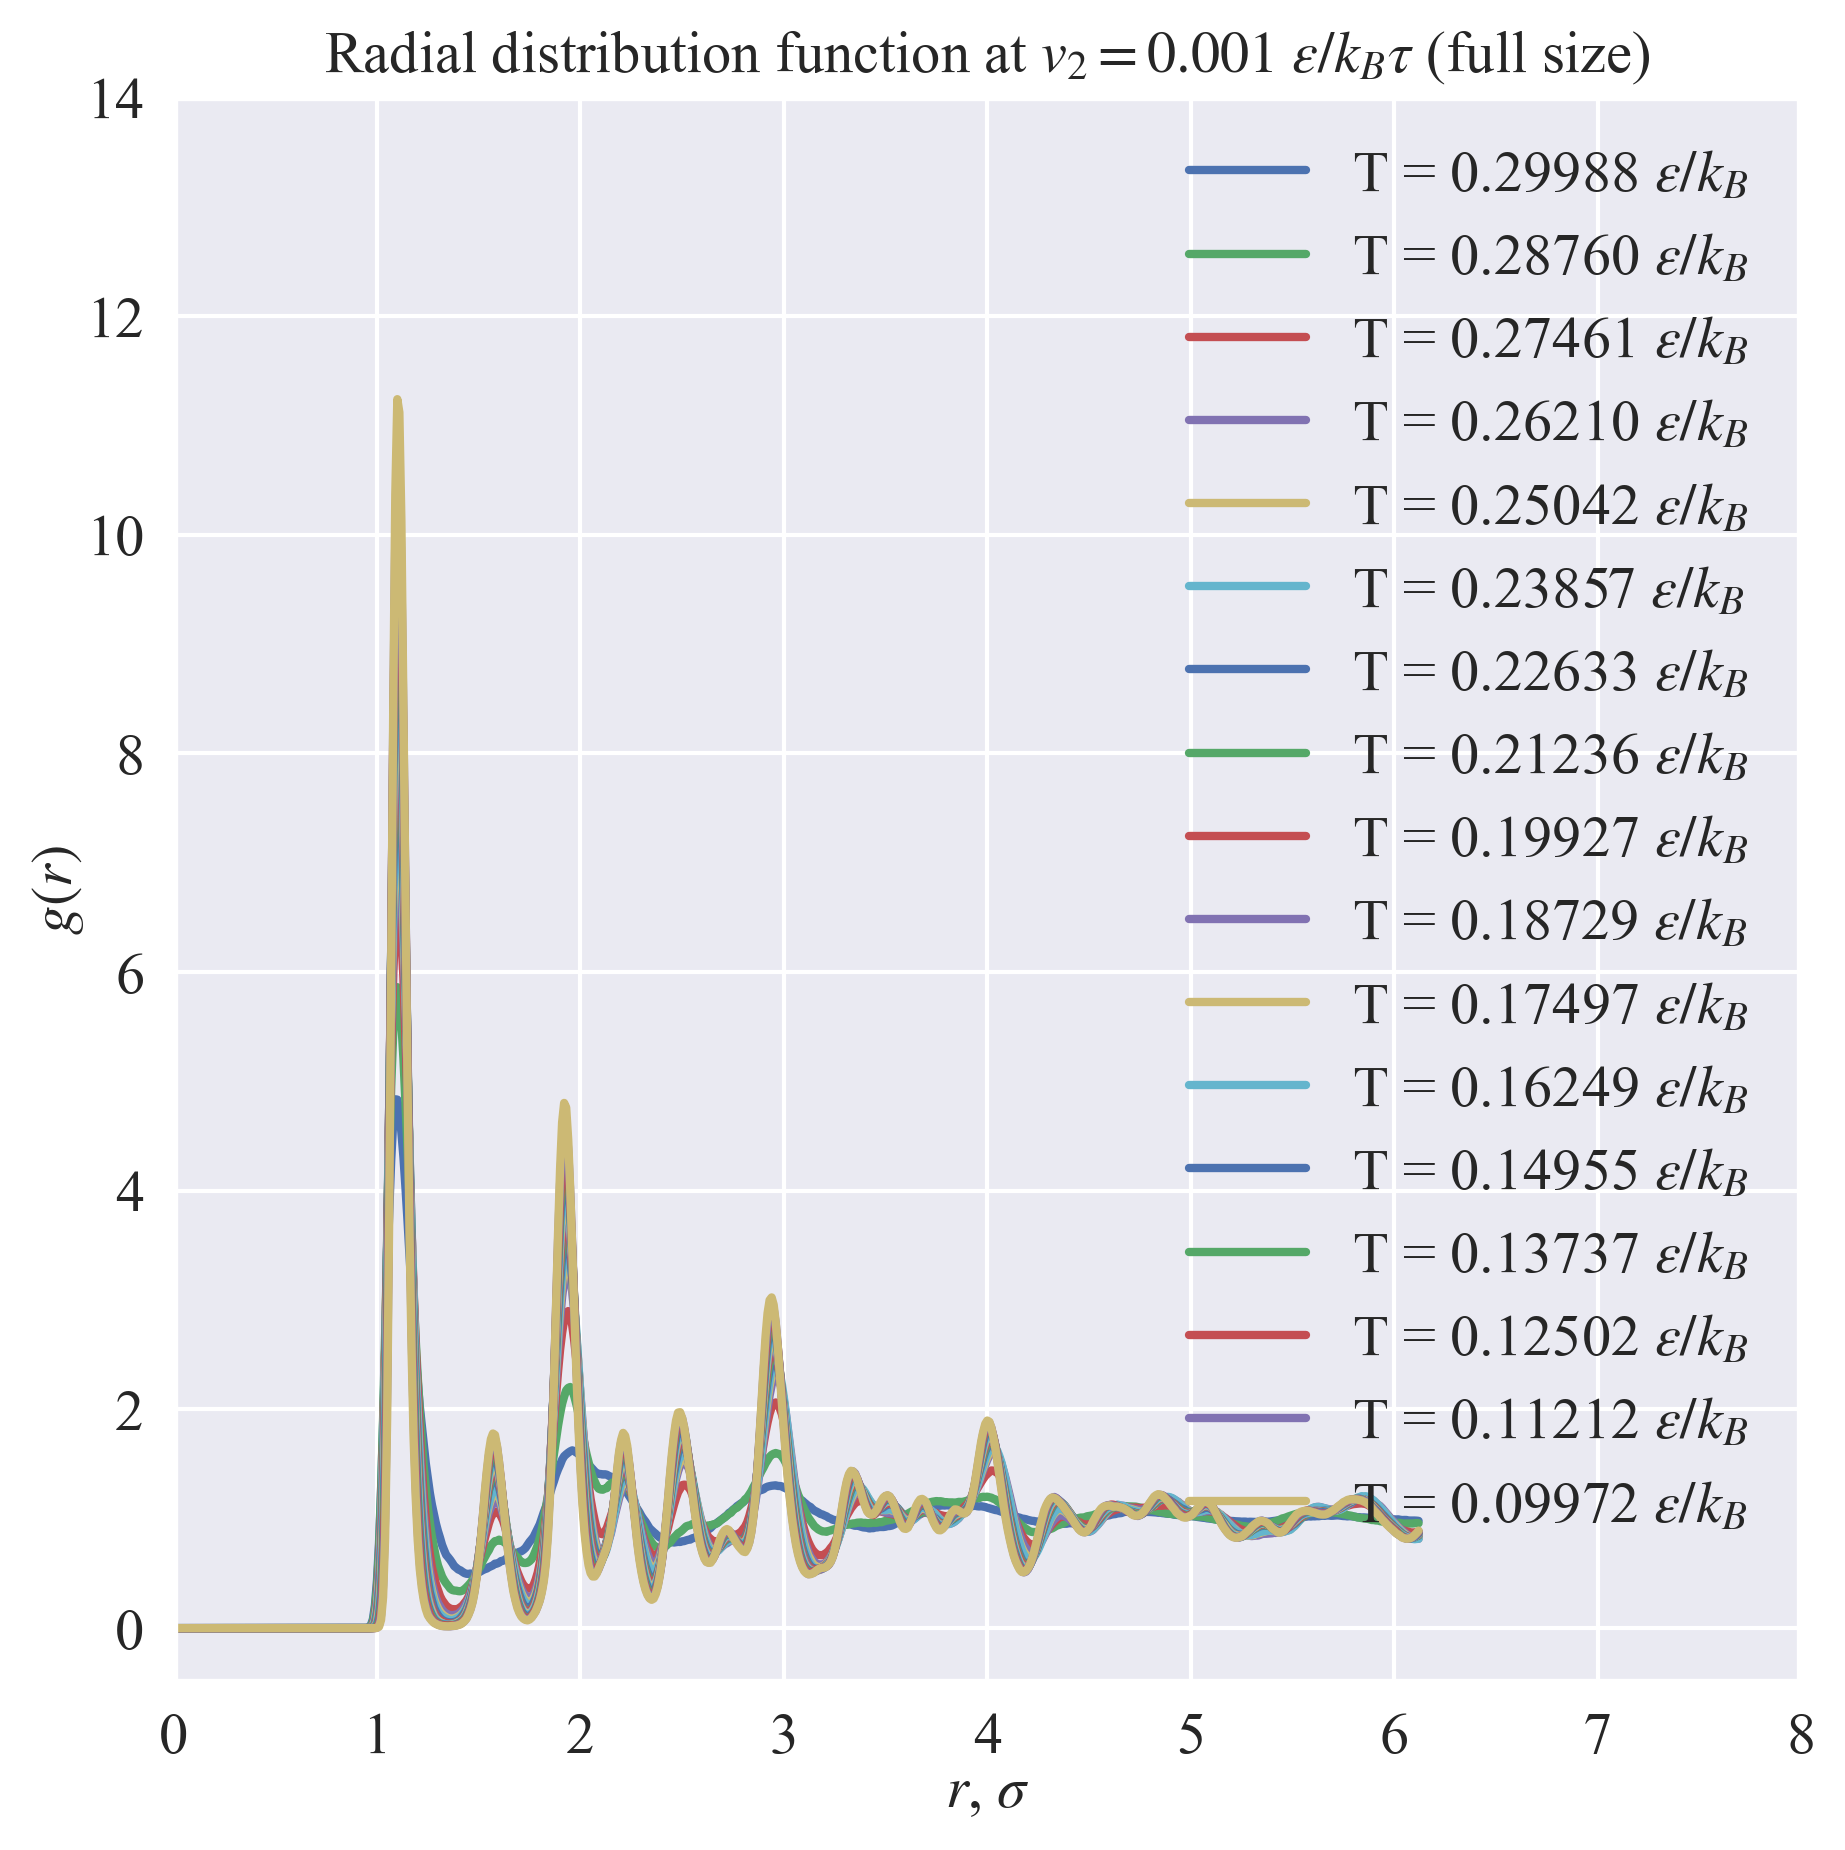

In [12]:
pp_slow.plot_rdf(
    shift=0.0,
    left=0,
    right=8,
    bottom=-0.5, 
    top=14,
    figsize=FIGSIZE,
    title=r'Radial distribution function at $v_2 = 0.001~\varepsilon / k_B\tau$ (full size)',
    filename_postfix='full_size',
)

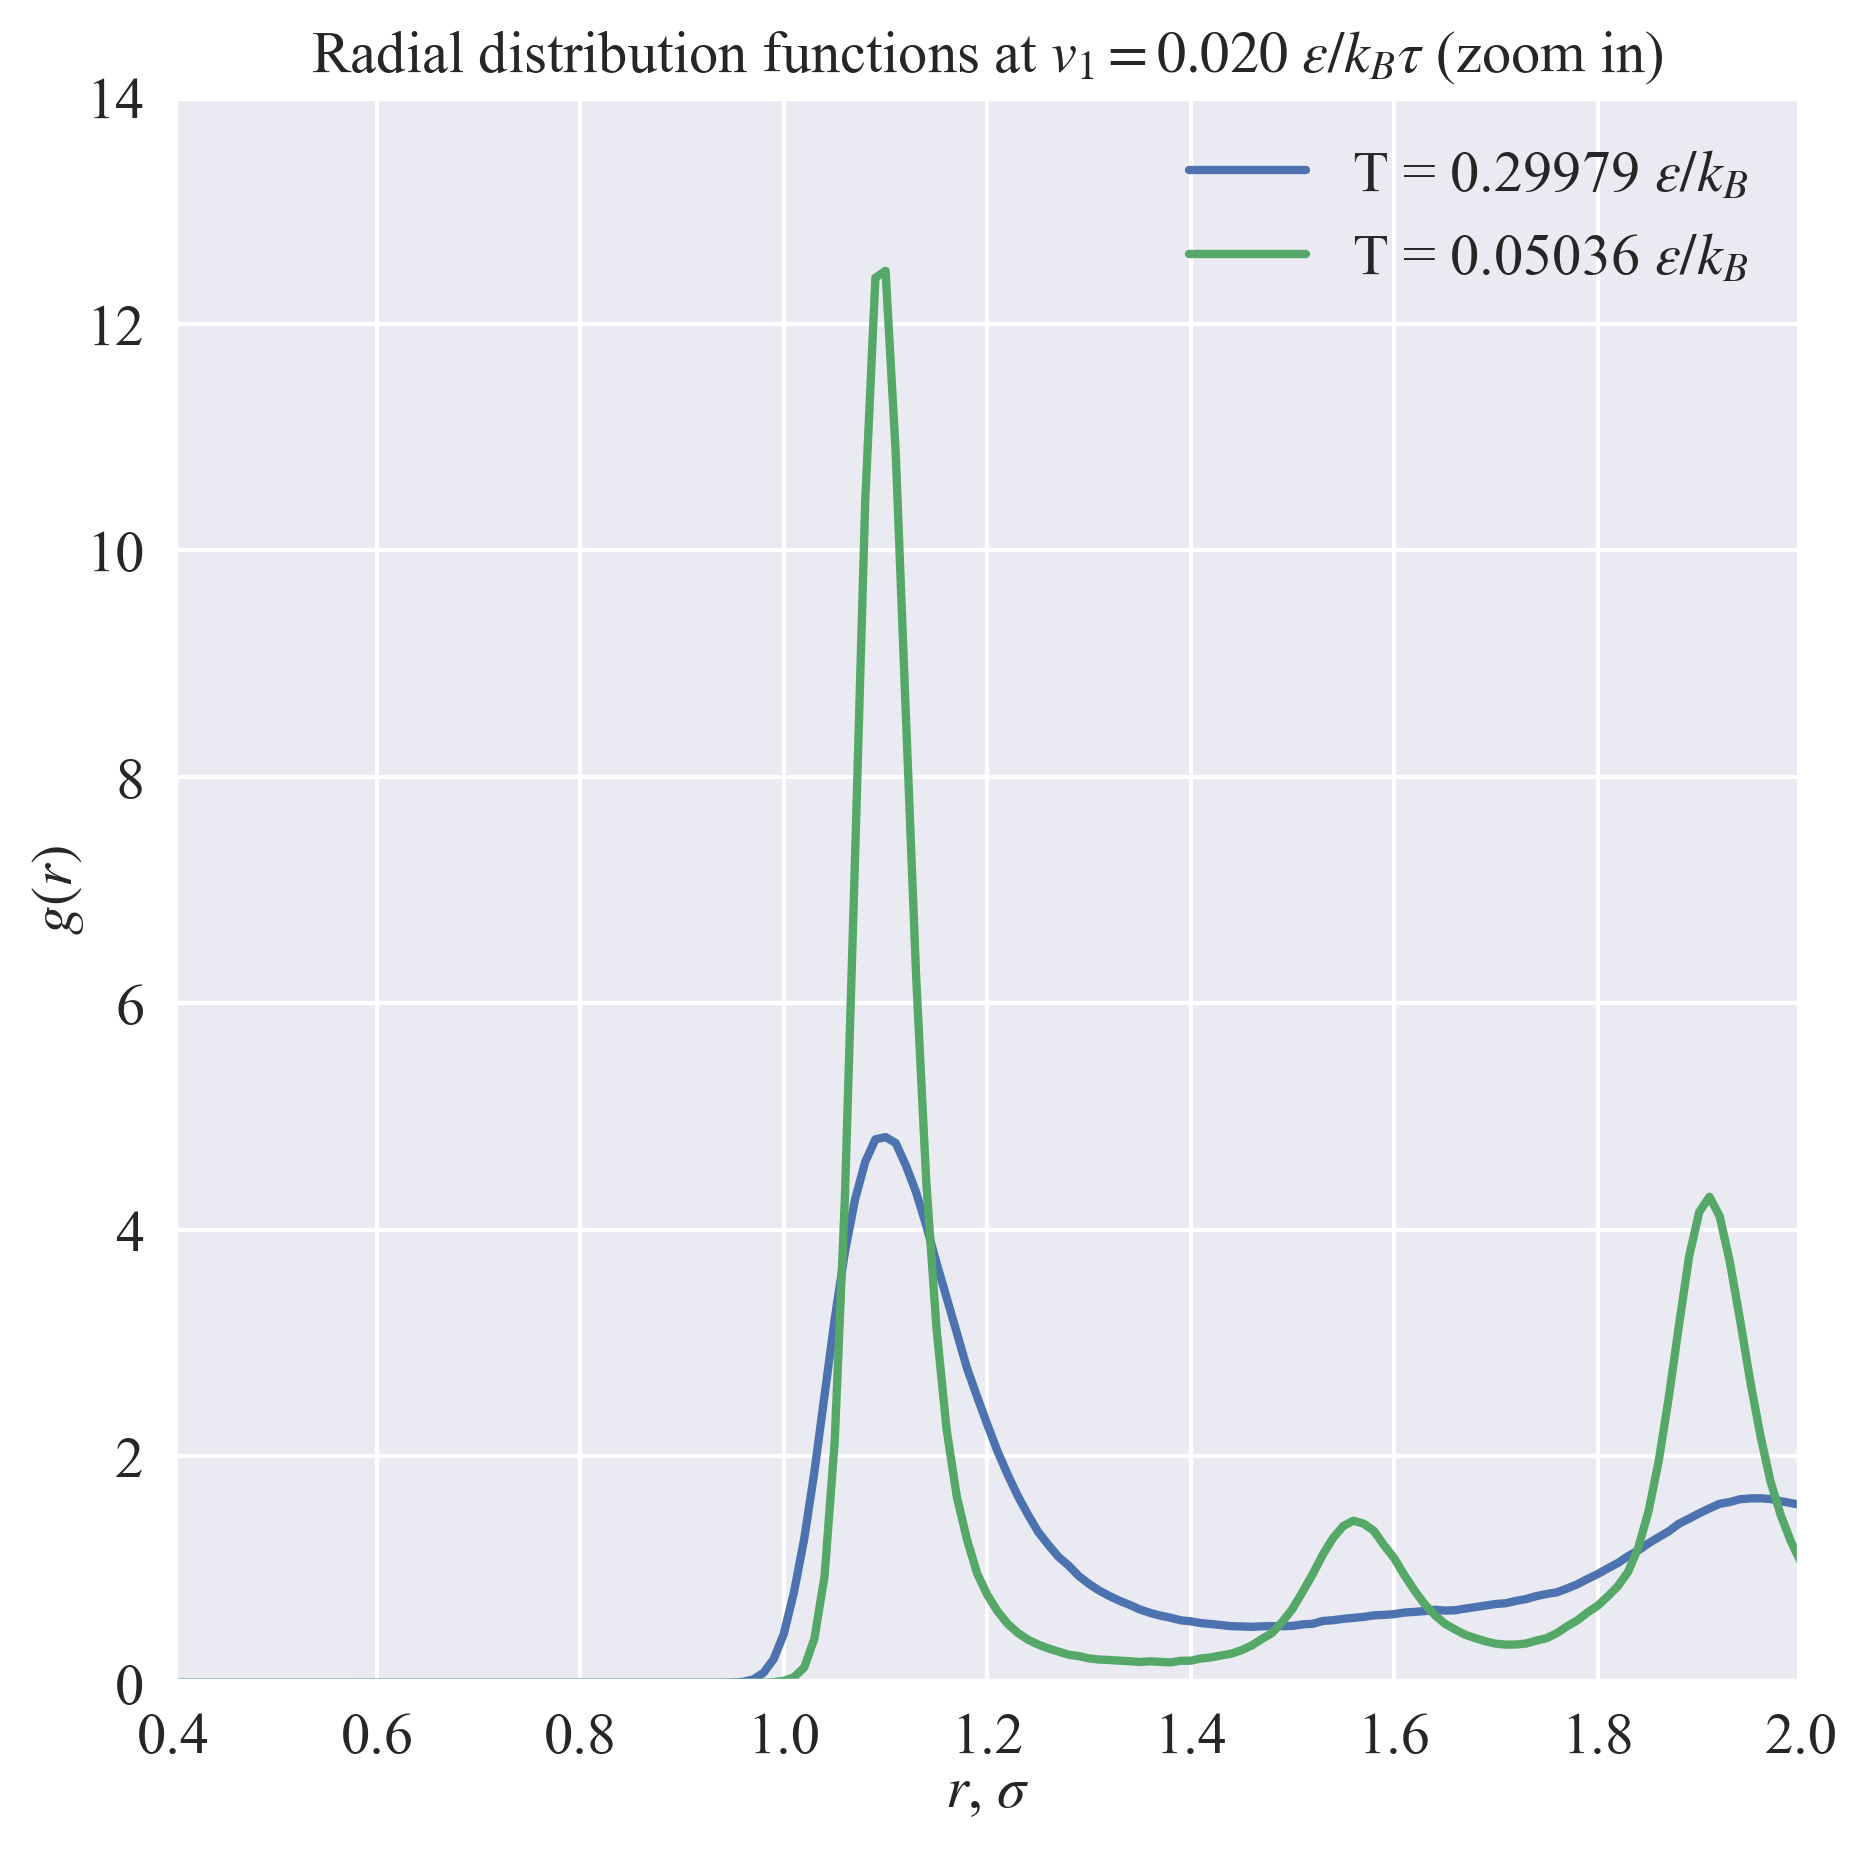

In [13]:
pp_normal.plot_rdf(
    shift=0.0,
    left=0.4, 
    right=2,
    bottom=0,
    top=14, 
    figsize=FIGSIZE,
    title=r'Radial distribution functions at $v_1 = 0.020~\varepsilon / k_B\tau$ (zoom in)',
    filename_postfix='full_size',
)

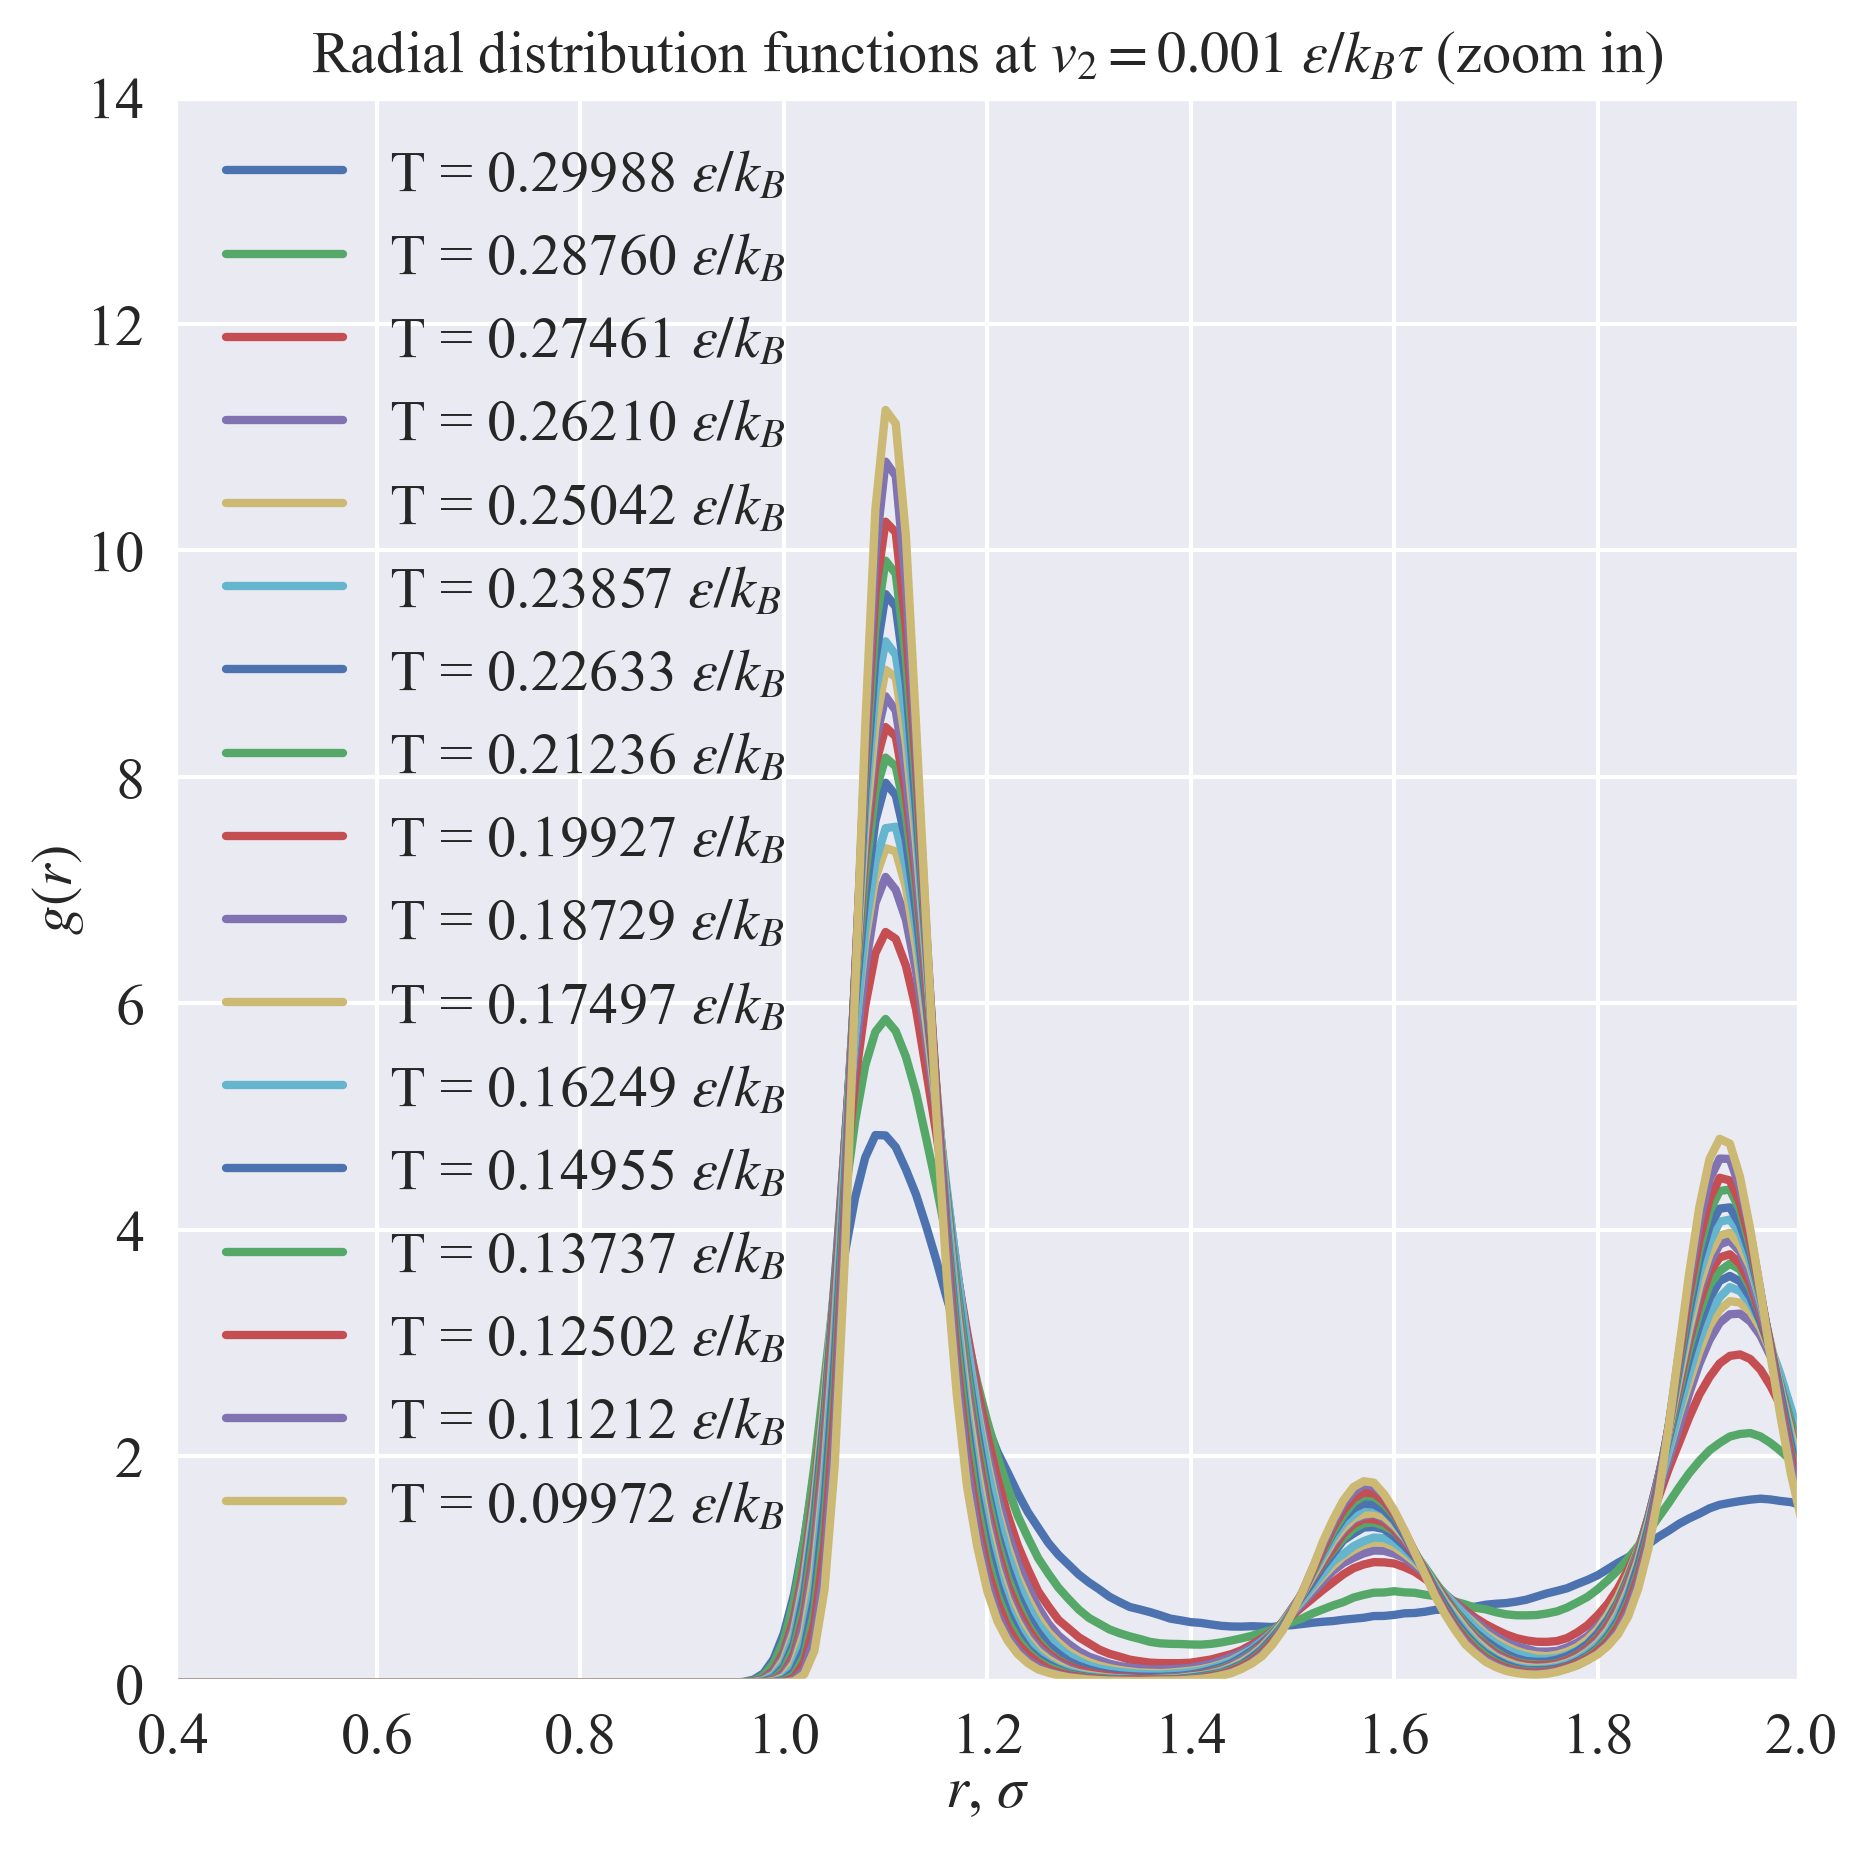

In [14]:
pp_slow.plot_rdf(
    shift=0.0,
    left=0.4, 
    right=2,
    bottom=0,
    top=14, 
    figsize=FIGSIZE,
    title=r'Radial distribution functions at $v_2 = 0.001~\varepsilon / k_B\tau$ (zoom in)',
    filename_postfix='zoom_in',
)

#### Создаём таблицу со значениями RDF, где строка соответствует значению температуры $T$, а столбец - расстоянию $r$.

In [15]:
rr = RegressionRDF(
    post_processor=pp_slow, 
    setups=setups_slow,
    test_temperatures=test_temperatures,
)
rdf_table = rr.get_rdf_table()
rdf_table

radius,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,6.03,6.04,6.05,6.06,6.07,6.08,6.09,6.10,6.11,6.12
setup_16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.843035,0.827426,0.821858,0.817484,0.819325,0.823168,0.834216,0.851033,0.869601,0.892238
setup_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.844500,0.831363,0.824919,0.816966,0.818585,0.823697,0.830777,0.842498,0.862558,0.883619
setup_14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.847136,0.837024,0.829947,0.822447,0.822210,0.823997,0.832976,0.845252,0.860390,0.878734
setup_13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.854466,0.841521,0.828885,0.823723,0.820392,0.822503,0.833551,0.843953,0.858183,0.875831
setup_12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.856746,0.841115,0.830922,0.822194,0.818842,0.818909,0.826093,0.835357,0.847277,0.864817
setup_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.863606,0.850587,0.841763,0.830011,0.826216,0.823434,0.828280,0.836753,0.850119,0.866388
setup_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.865043,0.849567,0.837796,0.831172,0.825201,0.823897,0.827192,0.833523,0.844066,0.856951
setup_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.864618,0.853474,0.842505,0.834925,0.830107,0.826443,0.831643,0.836319,0.848139,0.862213
setup_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.869011,0.854875,0.846061,0.839983,0.832061,0.830347,0.829097,0.836369,0.844413,0.854865
setup_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.876981,0.860901,0.846679,0.837127,0.830350,0.828493,0.828540,0.829448,0.840600,0.849954


#### К каждому столбцу $g(T, r=r_i)$ применим алгоритм линейной регрессии. То есть будем искать функции вида $g_i = k_iT + b_i$ Ниже показаны значения расстояния между частицами $r_i$, соответствующие значения коэффициентов $k_i, b_i$ и значения среднеквадратичной ошибки RMSE

In [16]:
predicted_rdf_points = rr.run_linear_regressions(
    is_printed=True,
    is_plotted=False,
)
for key, value in predicted_rdf_points.items():
    predicted_rdf_points[key] = np.array(value)

r = 0.93; k =  0.00006; b = -0.00001; RMSE = 0.00001
r = 0.94; k =  0.00083; b = -0.00013; RMSE = 0.00009
r = 0.95; k =  0.00460; b = -0.00071; RMSE = 0.00029
r = 0.96; k =  0.02266; b = -0.00347; RMSE = 0.00135
r = 0.97; k =  0.09455; b = -0.01421; RMSE = 0.00464
r = 0.98; k =  0.31899; b = -0.04679; RMSE = 0.01290
r = 0.99; k =  0.87609; b = -0.12350; RMSE = 0.02836
r = 1.00; k =  1.97102; b = -0.26112; RMSE = 0.04520
r = 1.01; k =  3.73984; b = -0.44558; RMSE = 0.05122
r = 1.02; k =  6.06510; b = -0.58989; RMSE = 0.03385
r = 1.03; k =  8.22905; b = -0.48270; RMSE = 0.05295
r = 1.04; k =  8.93383; b =  0.19484; RMSE = 0.15817
r = 1.05; k =  6.94930; b =  1.70061; RMSE = 0.26051
r = 1.06; k =  1.25928; b =  4.18050; RMSE = 0.30876
r = 1.07; k = -7.06558; b =  7.25476; RMSE = 0.30822
r = 1.08; k = -16.00879; b = 10.28384; RMSE = 0.27268
r = 1.09; k = -23.33639; b = 12.64634; RMSE = 0.26116
r = 1.10; k = -26.96818; b = 13.77936; RMSE = 0.28554
r = 1.11; k = -26.73533; b = 13.64121; RMSE

r = 3.12; k =  2.37600; b =  0.16317; RMSE = 0.09590
r = 3.13; k =  2.20344; b =  0.17954; RMSE = 0.10331
r = 3.14; k =  1.99913; b =  0.20790; RMSE = 0.10694
r = 3.15; k =  1.81440; b =  0.23776; RMSE = 0.10893
r = 3.16; k =  1.65767; b =  0.26796; RMSE = 0.11066
r = 3.17; k =  1.52902; b =  0.29468; RMSE = 0.10984
r = 3.18; k =  1.44994; b =  0.31346; RMSE = 0.10725
r = 3.19; k =  1.38936; b =  0.33123; RMSE = 0.10407
r = 3.20; k =  1.37935; b =  0.33999; RMSE = 0.09907
r = 3.21; k =  1.34862; b =  0.35871; RMSE = 0.09226
r = 3.22; k =  1.30560; b =  0.38482; RMSE = 0.08430
r = 3.23; k =  1.20526; b =  0.43143; RMSE = 0.07597
r = 3.24; k =  1.01580; b =  0.50366; RMSE = 0.06679
r = 3.25; k =  0.76008; b =  0.60159; RMSE = 0.05726
r = 3.26; k =  0.36982; b =  0.73777; RMSE = 0.04606
r = 3.27; k = -0.08744; b =  0.89558; RMSE = 0.03703
r = 3.28; k = -0.58242; b =  1.06732; RMSE = 0.02745
r = 3.29; k = -1.09924; b =  1.24567; RMSE = 0.01657
r = 3.30; k = -1.55277; b =  1.40910; RMSE = 0

r = 5.32; k = -0.30928; b =  0.98250; RMSE = 0.03071
r = 5.33; k = -0.37614; b =  1.00443; RMSE = 0.03059
r = 5.34; k = -0.41852; b =  1.02035; RMSE = 0.02991
r = 5.35; k = -0.43058; b =  1.02710; RMSE = 0.02898
r = 5.36; k = -0.36991; b =  1.01525; RMSE = 0.02848
r = 5.37; k = -0.30523; b =  0.99981; RMSE = 0.02778
r = 5.38; k = -0.20226; b =  0.97463; RMSE = 0.02634
r = 5.39; k = -0.06940; b =  0.94106; RMSE = 0.02480
r = 5.40; k =  0.06031; b =  0.90724; RMSE = 0.02504
r = 5.41; k =  0.17391; b =  0.87778; RMSE = 0.02426
r = 5.42; k =  0.25838; b =  0.85460; RMSE = 0.02473
r = 5.43; k =  0.33671; b =  0.83568; RMSE = 0.02464
r = 5.44; k =  0.36659; b =  0.82923; RMSE = 0.02575
r = 5.45; k =  0.34618; b =  0.83580; RMSE = 0.02729
r = 5.46; k =  0.30911; b =  0.84937; RMSE = 0.02736
r = 5.47; k =  0.22813; b =  0.87518; RMSE = 0.02863
r = 5.48; k =  0.14829; b =  0.90363; RMSE = 0.03014
r = 5.49; k =  0.03887; b =  0.93983; RMSE = 0.03057
r = 5.50; k = -0.05731; b =  0.97510; RMSE = 0

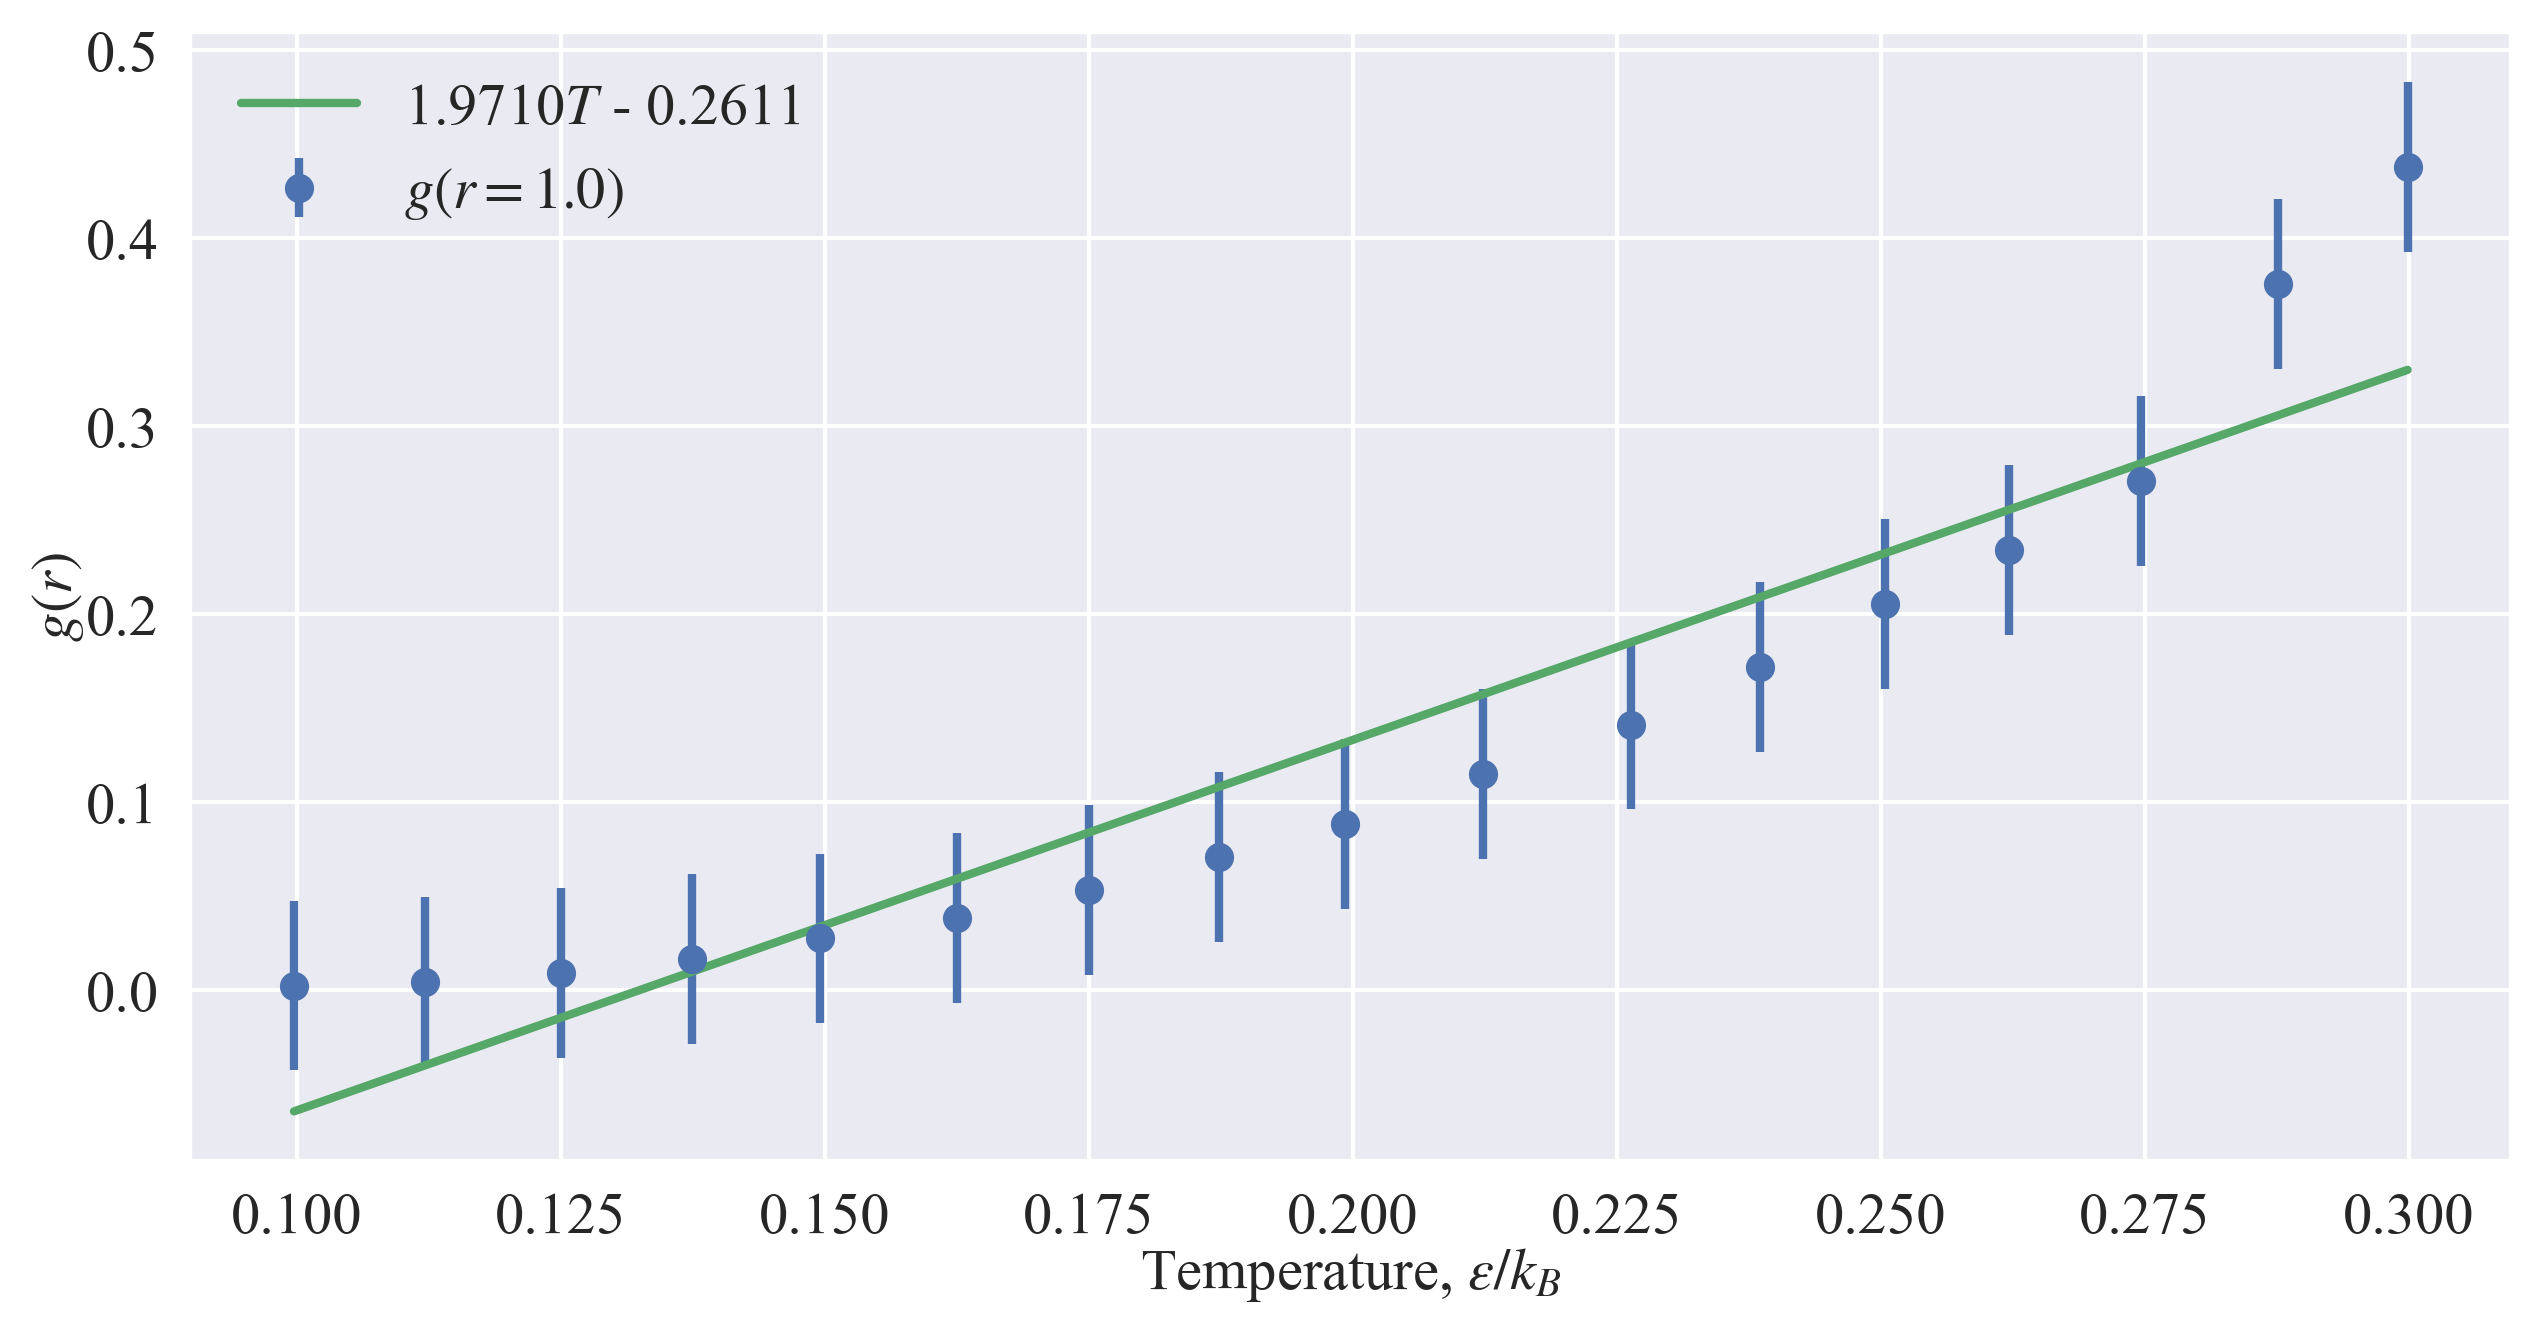

In [17]:
for column in (1.0, ):
    y = rr.rdf_table[column]
    k, b, fitted_data, error = rr.get_fitted_column(y_train=y)
    rr.plot_linear_regression(
        y_train=y,
        fitted_data=fitted_data,
        error=error,
        k=k, b=b, r=column,
        is_saved=True,
    )
    plt.close()

#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах (direct - посчитанные напрямую, predicted - предсказанные)

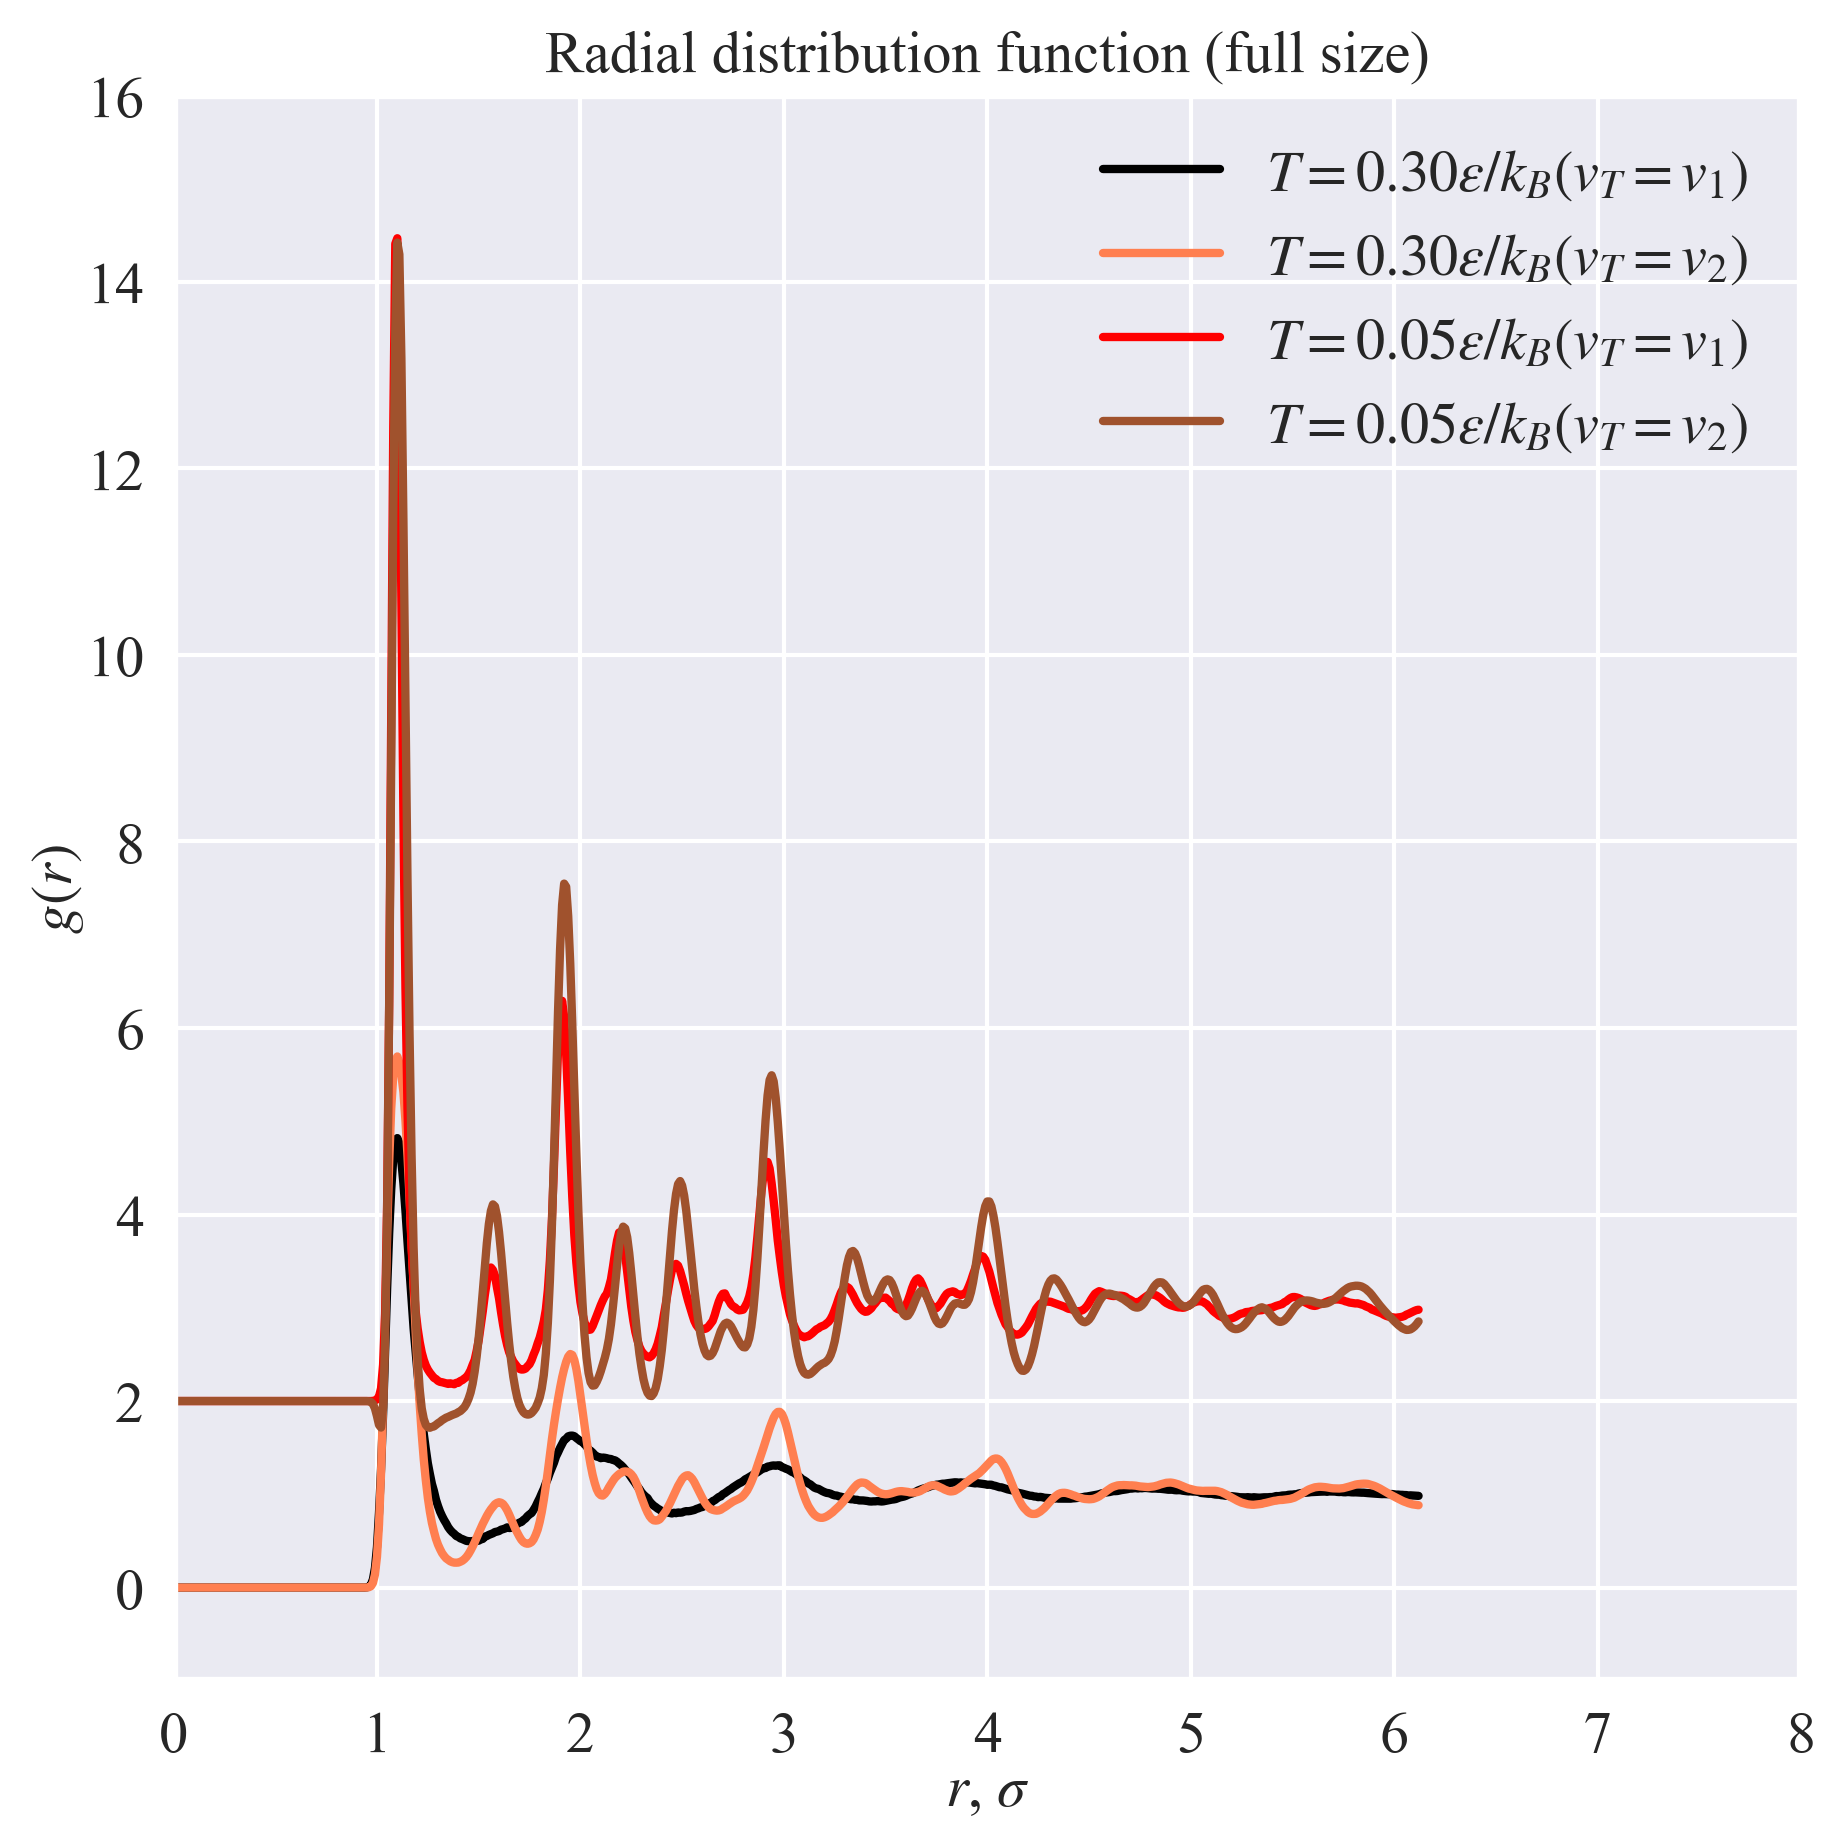

In [22]:
fig, ax = plt.subplots(figsize=FIGSIZE,)

for i, setup in enumerate(setups_normal):
    temperature = setup["temperature"]
    ax.plot(
        pp_normal.rdf.data['radius'],
        pp_normal.rdf.data[f'setup_{i}'] + i * 2,
        label=fr'$T = {temperature:.2f} \epsilon / k_B (v_T=v_1)$',
        color=COLORS[i],
    );
    ax.plot(
        rdf_table.columns.values, 
        predicted_rdf_points[temperature] + i * 2,
        label=fr'$T = {temperature:.2f} \epsilon / k_B (v_T=v_2)$',
        color=COLORS[-i-1],
    );
    
ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0, 
    right=8,
);
ax.set_ylim(
    bottom=-1, 
    top=16,
);
ax.set_title('Radial distribution function (full size)')
ax.legend();

save_plot(f'rdf_with_predicted_full_size_{PLOT_FILENAME_POSTFIX}.png')

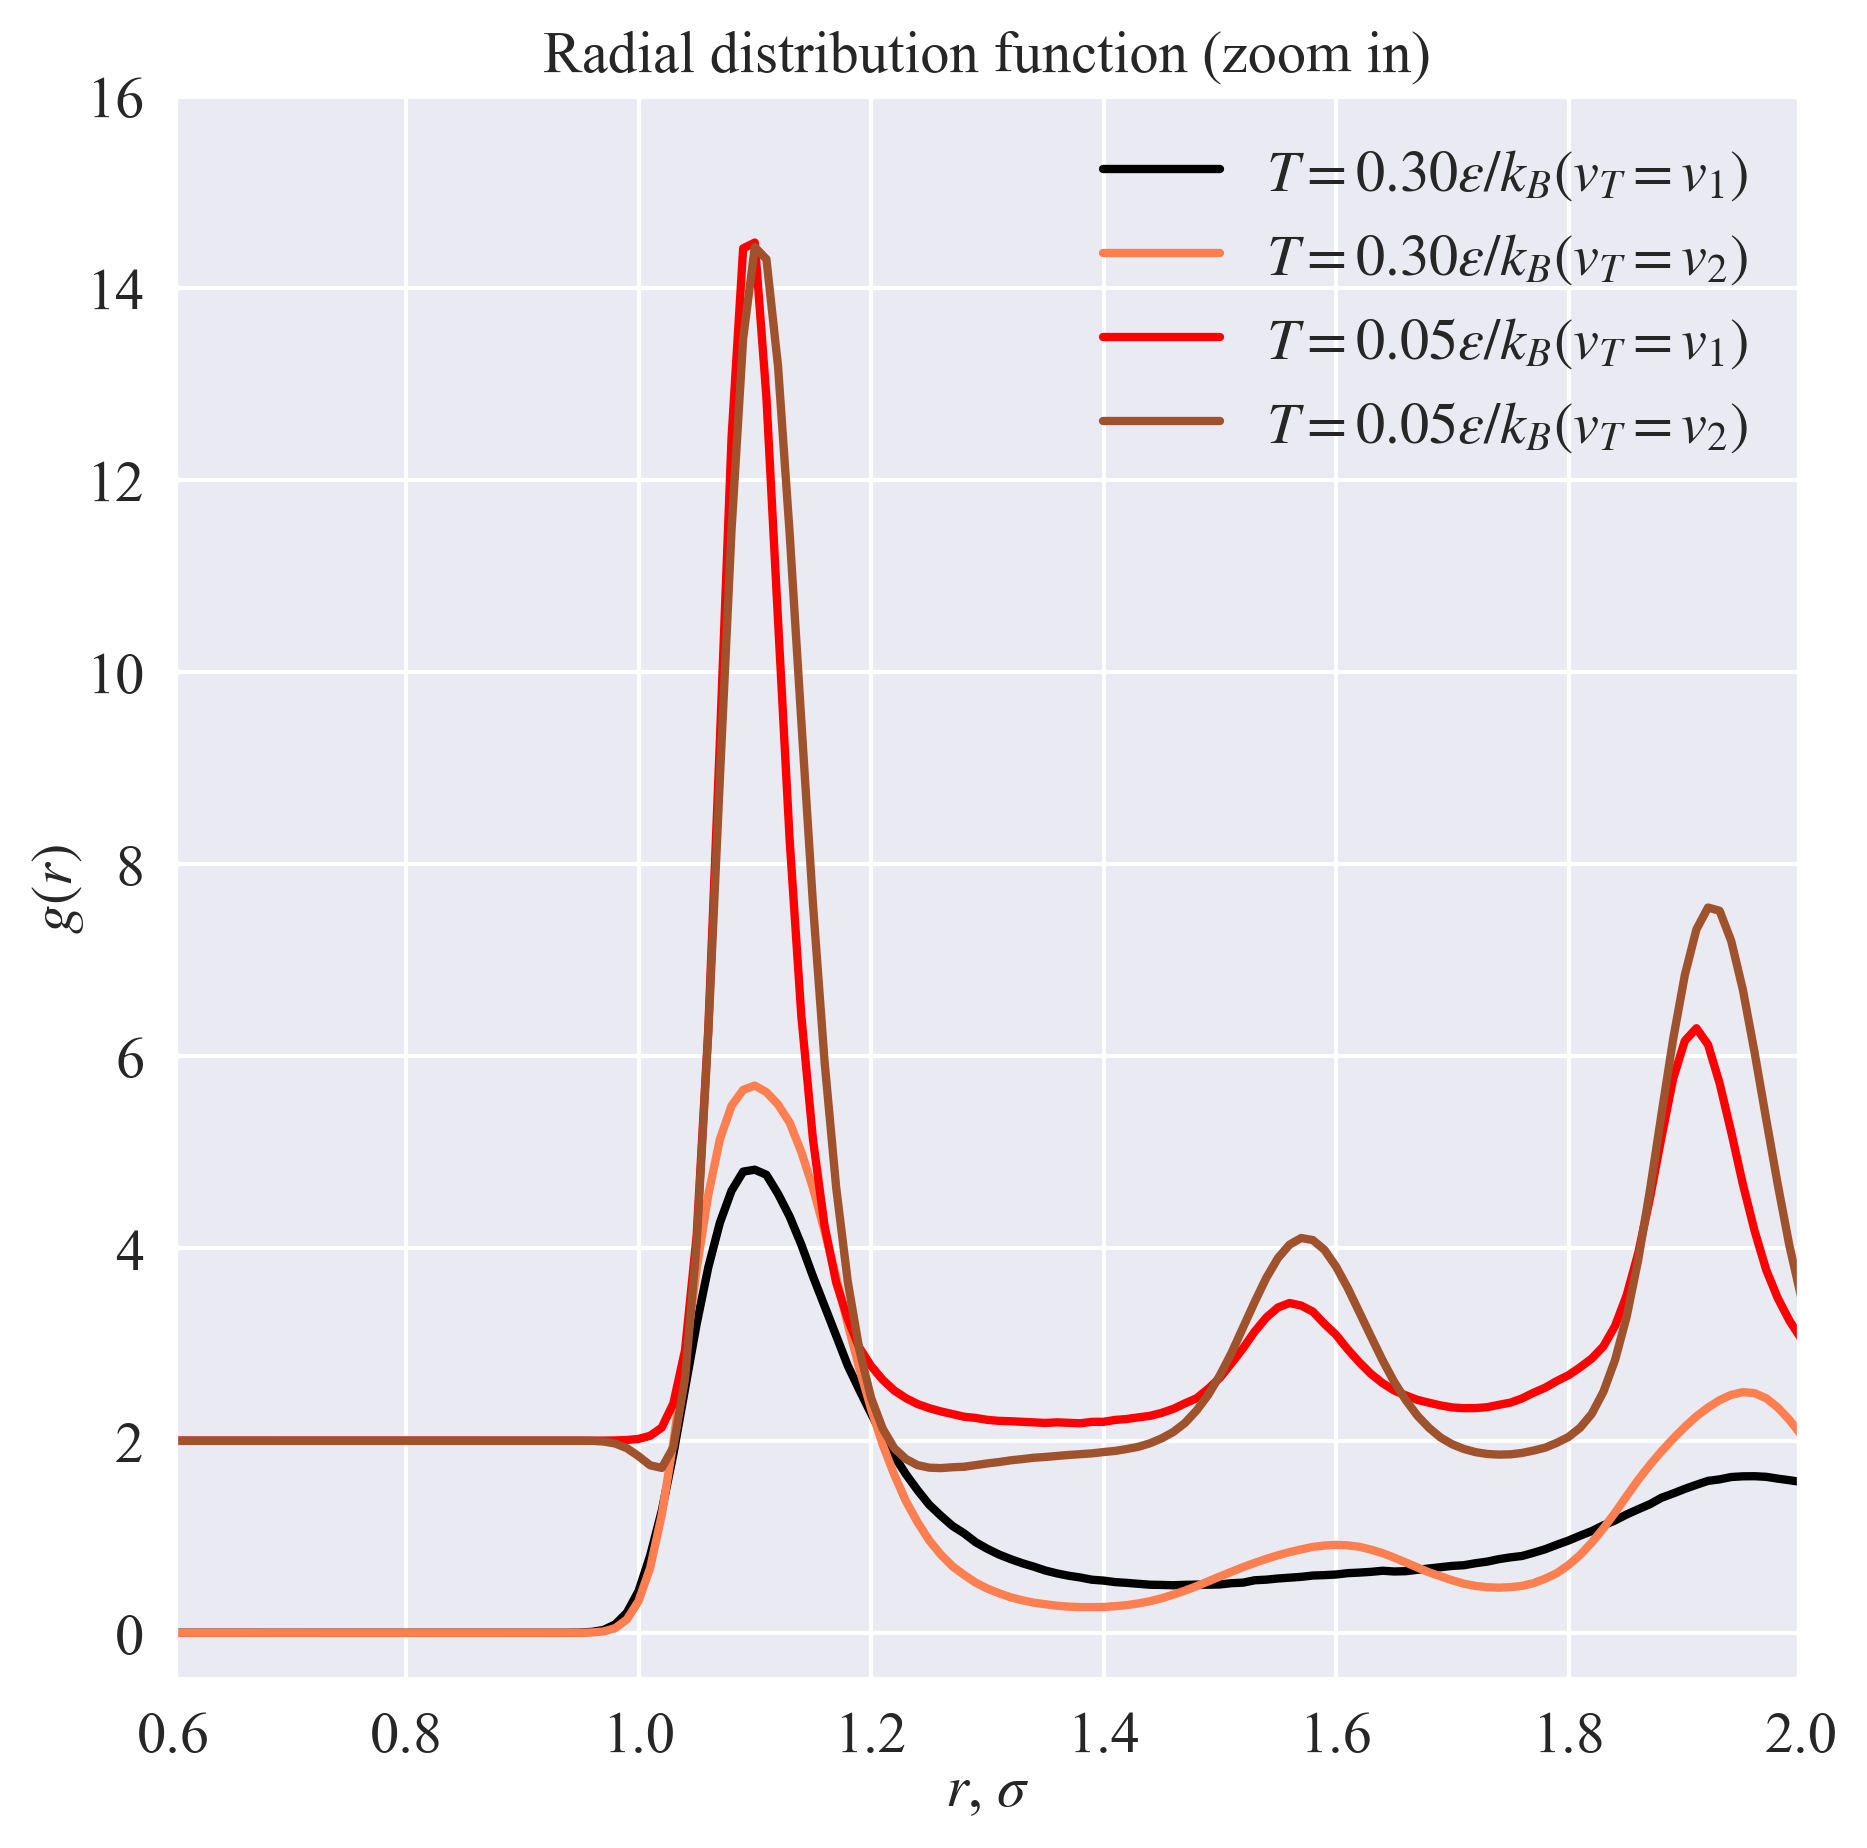

In [21]:
fig, ax = plt.subplots(figsize=FIGSIZE,)

for i, setup in enumerate(setups_normal):
    temperature = setup["temperature"]
    ax.plot(
        pp_normal.rdf.data['radius'],
        pp_normal.rdf.data[f'setup_{i}'] + i * 2,
        label=fr'$T = {temperature:.2f} \epsilon / k_B (v_T=v_1)$',
        color=COLORS[i],
    );
    ax.plot(
        rdf_table.columns.values, 
        predicted_rdf_points[temperature] + i * 2,
        label=fr'$T = {temperature:.2f} \epsilon / k_B (v_T=v_2)$',
        color=COLORS[-i-1],
    );

ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0.6, 
    right=2,
);
ax.set_ylim(
    bottom=-0.5, 
    top=16,
);
ax.set_title('Radial distribution function (zoom in)')
ax.legend();

save_plot(f'rdf_with_predicted_zoom_in_{PLOT_FILENAME_POSTFIX}.png')